In [1]:
# Load in the data for different states (unseen)

import numpy as np
import folktables
from folktables import ACSDataSource, ACSIncome

import os
import sys
import copy
sys.path.append('..')
import random
import FairCertModule
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from FullyConnected import FullyConnected
import pytorch_lightning as pl

SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

dataset = "Folk"
TEST_EPSILON = 0.05

import folk_utils
X_train, X_test, X_val, y_train, y_test, y_val, lp_epsilon, sr_epsilon = folk_utils.get_dataset(dataset)


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


In [2]:
f_epsilon = lp_epsilon

In [3]:

def get_data_states(dataset, year):
    state_X_tests = []; state_y_tests = []
    state_lrs = []; state_srs = []
    year = str(year)
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    for state in states:
        X_train, X_test, X_val, y_train, y_test, y_val, lp_epsilon, sr_epsilon = folk_utils.get_dataset(dataset, year, state)
        state_X_tests.append(X_test)
        state_y_tests.append(y_test)
        state_lrs.append(lp_epsilon); state_srs.append(sr_epsilon)
    return state_X_tests, state_y_tests



In [4]:
# Load in the data for different years (unseen)

def get_data_years(dataset, state):
    year_X_tests = []
    year_y_tests = []
    years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021']
    for year in years:
        try:
            X_train, X_test, X_val, y_train, y_test, y_val, lp_epsilon, sr_epsilon = folk_utils.get_dataset(dataset, year, state)
            year_X_tests.append(X_test)
            year_y_tests.append(y_test)
            #state_lrs.append(lp_epsilon); state_srs.append(sr_epsilon)
        except:
            pass
    return year_X_tests, year_y_tests



In [5]:
# Load in different networks

MODEL_STATE  = 'CA'
MODEL_YEAR   = '2015'
MODEL_WIDTH  = '256'
MODEL_METRIC = 'LP'

# SGD
sgd_id = "SGD" #'FCN_s=%s_y=%s_w=%s_f=%s_m=%s'%(MODEL_STATE, MODEL_YEAR, MODEL_WIDTH, "NONE", "NONE")

pgd_id = "FAIR-PGD" #'FCN_s=%s_y=%s_w=%s_f=%s_m=%s'%(MODEL_STATE, MODEL_YEAR, MODEL_WIDTH, MODEL_METRIC, "FAIR-PGD")

ibp_id = "FAIR-IBP" #'FCN_s=%s_y=%s_w=%s_f=%s_m=%s'%(MODEL_STATE, MODEL_YEAR, MODEL_WIDTH, MODEL_METRIC, "FAIR-IBP")

glob_id = "FAIR-GLOB"

ibpg_id = "FAIR-GLOB"

def load_model_from_id(model_id, dataset, width=MODEL_WIDTH):
    print("***")
    #model = FullyConnected(hidden_lay=2, hidden_dim=int(MODEL_WIDTH),  learning_rate = 0.001, mode='FAIR-IBP')
    print(dataset)
    model = FullyConnected(hidden_lay=2, hidden_dim=256, dataset=dataset)
    ckpt = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    checkpoint = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    model.load_state_dict(torch.load('%sModels/%s.pt'%(dataset, model_id)))
    return model

sgd_model = load_model_from_id(sgd_id, dataset)
pgd_model = load_model_from_id(pgd_id, dataset)
ibp_model = load_model_from_id(ibp_id, dataset)
glob_model = load_model_from_id(glob_id, dataset)


***
Folk
***
Folk
***
Folk
***
Folk


In [6]:

from FairCertModule import * 

def fair_PGD_local(model, x_natural, lab, vec, eps, nclasses, iterations=10):
    x = x_natural.detach()
    eps_vec = vec*eps
    #noise = (eps_vec*torch.zeros_like(x).uniform_(0, 1))
    noise = (-2*eps_vec) * torch.zeros_like(x).uniform_(0, 1) + eps_vec
    #print("EPS  : ", eps_vec)
    #print("NOISE: ", abs(noise))
    x = x + (noise*eps)
    for i in range(iterations):
        x.requires_grad_()
        with torch.enable_grad():
            logits = model(x)
            loss = F.cross_entropy(logits, lab)
        grad = torch.autograd.grad(loss, [x])[0]
        x = x + (eps_vec/iterations * torch.sign(grad.detach()))
        #x = x.detach() + 0.5 * torch.sign(grad.detach())
        #x = torch.min(torch.max(x, x_natural - eps_vec), x_natural + eps_vec)
        x = torch.clip(x, x_natural-eps_vec, x_natural+eps_vec)  
    #print( abs(x_natural - x))
    #weights = [t for t in model.parameters()]
    #logit_l, logit_u = interval_bound_forward(model, weights, x, vec, 0.0)
    #print(logit_l)
    #print(logit_u)
    #print("PRED: ", F.softmax(logit_u))
    return x 

import torchmetrics
def evaluate_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = torch.Tensor(y_pred)
    a = torchmetrics.Accuracy(task='binary', average='micro', num_classes=2)
    acc = a(torch.argmax(y_pred, -1), y_test)
    #acc = torch.sum(torch.eq(torch.argmax(y_pred, -1), y_test).to(torch.float32)) / len(y_test)
    return acc

def evaluate_delta_PGD(model, inp, lab, vec, eps, nclasses, iterations=10, ret_max=True):
    y_pred = F.softmax(model(inp)).detach().numpy()
    x_adv = fair_PGD_local(model, inp, lab, vec, eps, nclasses, iterations)
    y_adv = F.softmax(model(x_adv)).detach().numpy()
    #print("PRED Torch: ", y_adv)
    pgd_delta = np.max(np.abs(y_pred - y_adv), axis=1)
    if(ret_max):
        return np.mean(pgd_delta)
    else:
        return pgd_delta
    
def evaluate_delta_IBP(model, inp, lab, vec, eps, nclasses, ret_max=True):
    """
    This class only works for binary classification at the moment. Can be generalized
    with a bit of effort modifying the for loop.
    """
    weights = [t for t in model.parameters()]
    logit_l, logit_u = interval_bound_forward(model, weights, inp, vec, eps)
    worst_delta = 0
    v1 = torch.nn.functional.one_hot(lab, num_classes=nclasses)
    v2 = 1 - torch.nn.functional.one_hot(lab, num_classes=nclasses)
    min_logit = torch.add(torch.multiply(v2, logit_u), torch.multiply(v1, logit_l))
    max_logit = torch.add(torch.multiply(v1, logit_u), torch.multiply(v2, logit_l))
    min_i_softmax = F.softmax(min_logit, dim=-1)
    max_i_softmax = F.softmax(max_logit, dim=-1)
    delta = (max_i_softmax - min_i_softmax)
    delta = delta.detach().numpy()
    delta = np.abs(delta)
    if(ret_max):
        return np.mean(np.max(delta, axis=1))
    else:
        return np.max(np.squeeze(delta), axis=1)


In [7]:
# TIGHTNESS EXPLORATION: 
f_epsilon = torch.Tensor(f_epsilon)
inp = torch.Tensor(X_test[0:200]).float()
inp = torch.unsqueeze(inp, dim=0)
lab = torch.Tensor(y_test[0:200]).long()

ibp_ibp = evaluate_delta_IBP(glob_model, inp, lab, f_epsilon, TEST_EPSILON, 2, ret_max=False)
glob_model(torch.squeeze(inp))
ibp_pgd = evaluate_delta_PGD(glob_model, torch.squeeze(inp), lab, 
                             f_epsilon, TEST_EPSILON, 2, iterations=40, ret_max=False)




/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [8]:

sgd_acc = evaluate_accuracy(sgd_model, X_test, y_test)
pgd_acc = evaluate_accuracy(pgd_model, X_test, y_test)
ibp_acc = evaluate_accuracy(ibp_model, X_test, y_test)
glob_acc = evaluate_accuracy(glob_model, X_test, y_test)
ibp_base_acc = copy.deepcopy(ibp_acc)
glob_base_acc = copy.deepcopy(glob_acc)

[tensor(0.8203), tensor(0.7822), tensor(0.7741), tensor(0.7717)]


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  del sys.path[0]


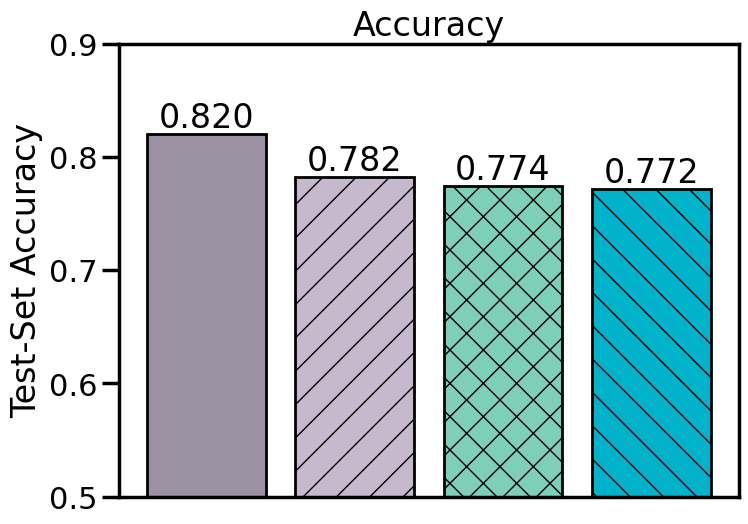

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')


vals = [sgd_acc, pgd_acc, ibp_acc, glob_acc]
print(vals)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

rects_1 = plt.bar(x=range(len(vals)), height=vals, edgecolor='k', 
                  color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"],
                  hatch=[' ', '/', 'x', '\\']) 

ax.bar_label(rects_1, labels=['%.3f'%e if e != 1 else '%.3f'%e for e in vals], 
                 padding=0, fontsize=24,  rotation=0, color='k', )

plt.ylim((0.5, 0.9))
#ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
ax.set_xticks([], [])
plt.ylabel('Test-Set Accuracy')
plt.title('Accuracy')
plt.show()

In [10]:

sgd_pgd = evaluate_delta_PGD(sgd_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2, iterations=25)
pgd_pgd = evaluate_delta_PGD(pgd_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2, iterations=25)
ibp_pgd = evaluate_delta_PGD(ibp_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2, iterations=25)
glob_pgd = evaluate_delta_PGD(glob_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2, iterations=25)


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  


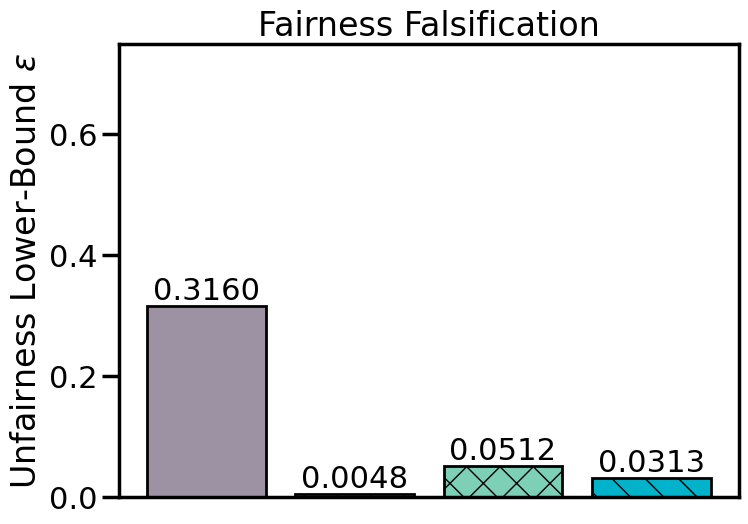

In [11]:
vals = [sgd_pgd, pgd_pgd, ibp_pgd, glob_pgd]
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

rects_1 = plt.bar(x=range(len(vals)), height=vals, edgecolor='k', 
                  color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"],
                  hatch=[' ', '/', 'x', '\\']) 

ax.bar_label(rects_1, labels=['%.4f'%e if e != 1 else '%.4f'%e for e in vals], 
                 padding=0, fontsize=22,  rotation=0, color='k', )

plt.ylim((min(vals)-0.25*min(vals), max(vals)+0.25*max(vals)))
#ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
ax.set_xticks([], [])
plt.ylabel(r'Unfairness Lower-Bound $\epsilon$')
plt.title('Fairness Falsification')
plt.ylim((0.0, 0.75))
plt.show()


In [12]:

sgd_ibp = evaluate_delta_IBP(sgd_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2)
pgd_ibp = evaluate_delta_IBP(pgd_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2)
ibp_ibp = evaluate_delta_IBP(ibp_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2)
glob_ibp = evaluate_delta_IBP(glob_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2)
ibp_base_ibp = copy.deepcopy(ibp_ibp)
glob_base_ibp = copy.deepcopy(glob_ibp)


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  import sys


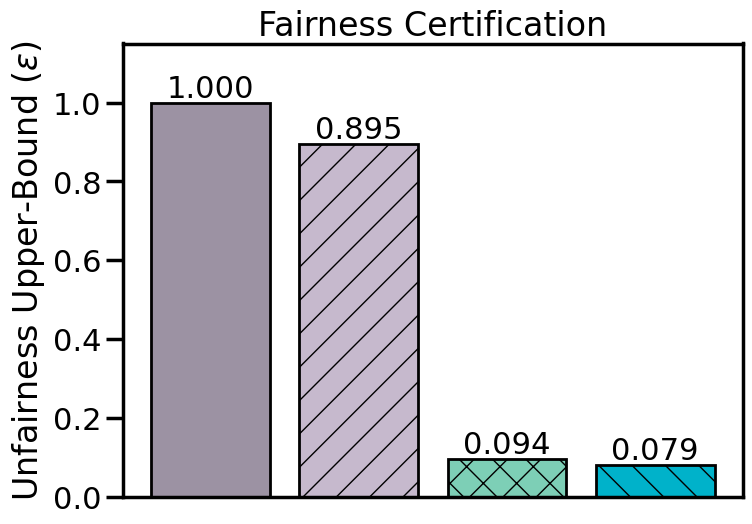

In [13]:

ibp_base_perf = ibp_ibp
vals = [sgd_ibp, pgd_ibp, ibp_ibp, glob_ibp]
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

rects_1 = plt.bar(x=range(len(vals)), height=vals, edgecolor='k', 
                  color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"],
                  hatch=[' ', '/', 'x', '\\']) 

ax.bar_label(rects_1, labels=['%.3f'%e if e != 1 else '%.3f'%e for e in vals], 
                 padding=0, fontsize=22,  rotation=0, color='k', )

plt.ylim((min(vals)-0.25*min(vals), max(vals)+0.25*max(vals)))
#ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
ax.set_xticks([], [])
plt.ylabel(r'Unfairness Upper-Bound ($\epsilon$)')
plt.title('Fairness Certification')
plt.ylim((0.0, 1.15))
plt.show()


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
/Users/matthewwicker/opt/anaconda3/envs/FairnessE

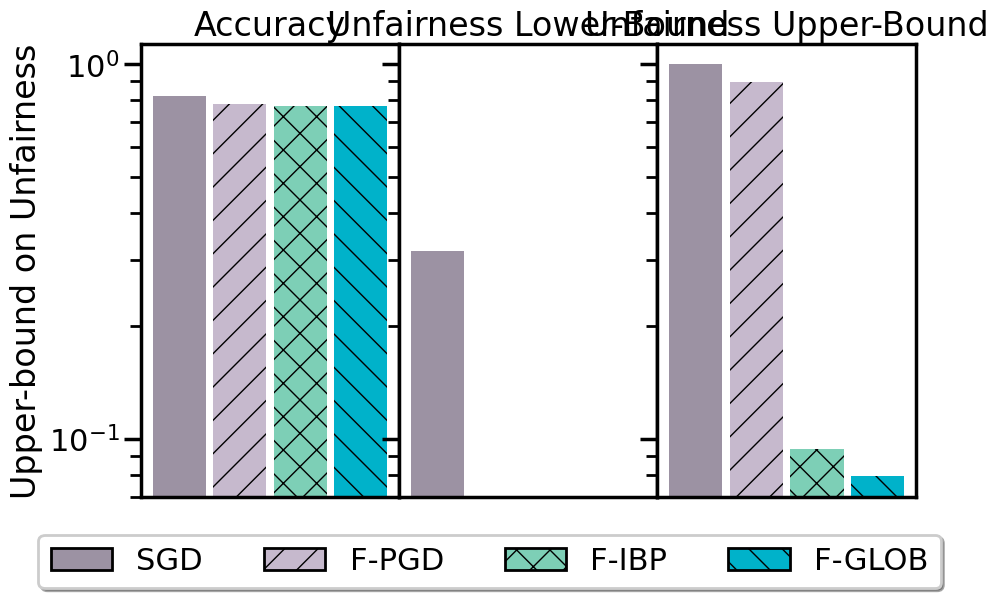

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
sns.set_context('poster')

fig = plt.figure(figsize=(10,6), dpi=100)
gs = fig.add_gridspec(1, 3, hspace=0, wspace=0)
(ax1, ax2, ax3) = gs.subplots(sharex='col', sharey='row')

ax1.set_title('Accuracy')
ax2.set_title('Unfairness Lower-Bound')
ax3.set_title('Unfairness Upper-Bound')


ax1.bar(x=[0.0, 0.25, 0.5, 0.75], height=[sgd_acc, pgd_acc, ibp_acc, glob_acc],
        color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"],
         hatch=[' ', '/', 'x', '\\'], width = 0.22)

ax2.bar(x=[0.0, 0.25, 0.5, 0.75], height= [sgd_pgd, pgd_pgd, ibp_pgd, glob_pgd],
        color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"],
         hatch=[' ', '/', 'x', '\\'], width = 0.22)


ax3.bar(x=[0.0, 0.25, 0.5, 0.75], height= [sgd_ibp, pgd_ibp, ibp_ibp, glob_ibp],
        color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"],
         hatch=[' ', '/', 'x', '\\'], width = 0.22)



ax3.set_xticks([])
ax2.set_xticks([])
ax1.set_xticks([])

legend_elements = [Patch(facecolor='#9C92A3', edgecolor='k', label='SGD', hatch=' '),
                   Patch(facecolor='#C6B9CD', edgecolor='k', label='F-PGD', hatch='/'),
                   Patch(facecolor='#7DCFB6', edgecolor='k', label='F-IBP', hatch='x'),
                   Patch(facecolor='#00B2CA', edgecolor='k', label='F-GLOB', hatch='\\')]


ax1.set_ylabel('Upper-bound on Unfairness')
plt.legend(handles=legend_elements,  loc='upper center', bbox_to_anchor=(-0.65, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.yscale('log')
plt.show()

In [15]:

glob_ibp = evaluate_delta_IBP(glob_model, X_test, y_test, f_epsilon, 0.05, 2, ret_max=False)
glob_pgd = evaluate_delta_PGD(glob_model, X_test, y_test, f_epsilon, 0.05, 2, iterations=100, ret_max=False)

tightness = glob_ibp - glob_pgd
print(" ")

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.0
0.046821278
0.29711422


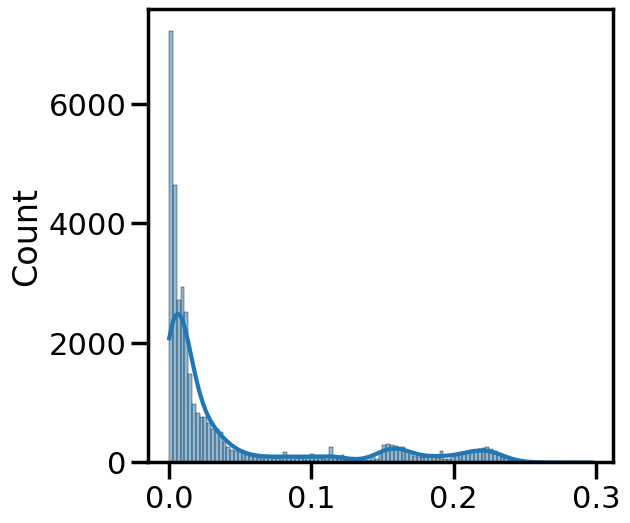

In [16]:
print(min(tightness))
print(np.mean(tightness))
print(max(tightness))
fig, ax = plt.subplots(figsize=(6,6), dpi=100)

sns.histplot(tightness, kde=True)

plt.show()

In [17]:
X_test_states, y_test_states = get_data_states('2015')

TypeError: get_data_states() missing 1 required positional argument: 'year'

In [ ]:
sgd_accs = []
pgd_accs = []
ibp_accs = []
glob_accs = []
for X, y in zip(X_test_states, y_test_states):
    #f_epsilon = FairCertModule.get_fairness_intervals(X, [-1],  metric="LP", use_sens=False, eps=1)
    #f_epsilon /= sum(f_epsilon)
    X = X[:,:-1]
    X = torch.Tensor(X)
    y = torch.Tensor(y).type(torch.LongTensor)
    sgd_acc = evaluate_accuracy(sgd_model, X, y)
    sgd_accs.append(sgd_acc)
    
    pgd_acc = evaluate_accuracy(pgd_model, X, y)
    pgd_accs.append(pgd_acc)
    
    ibp_acc = evaluate_accuracy(ibp_model, X, y)
    ibp_accs.append(ibp_acc)
    
    glob_acc = evaluate_accuracy(glob_model, X, y)
    glob_accs.append(glob_acc)

In [ ]:
"""
print(np.round(sgd_accs, 2))
print(min(sgd_accs), np.mean(sgd_accs), max(sgd_accs))
print("----")

print(np.round(pgd_accs, 2))
print(min(pgd_accs), np.mean(pgd_accs), max(pgd_accs))
print("----")

print(np.round(ibp_accs, 2))
print(min(ibp_accs), np.mean(ibp_accs), max(ibp_accs))
"""

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
vals = [sgd_accs, pgd_accs, ibp_accs, glob_accs]
fig, ax = plt.subplots(figsize=(6,9), dpi=100)
color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"]
rects_1 = sns.boxenplot(data=vals, palette=color) 

plt.ylim((0.5, 0.9))
ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
plt.ylabel('Accuracy')
plt.title('Accuracy w/ Geographic Shift')
plt.show()



In [ ]:
"""
from tqdm import tqdm
sgd_pgds = []
pgd_pgds = []
ibp_pgds = []
glob_pgds = []
for X, y in tqdm(zip(X_test_states, y_test_states)):
    #f_epsilon = FairCertModule.get_fairness_intervals(X, [-1],  metric="LP", use_sens=False, eps=1)
    f_epsilon = FairCertModule.get_explore_intervals(X, y, sens_maj_inds=[-1],
                                                  sens_min_inds=[-1], use_sens=False, eps=1)
    f_epsilon /= sum(f_epsilon)
    f_epsilon /= np.median(f_epsilon)
    X = X[:,:-1]
       
    X = torch.Tensor(X)
    y = torch.Tensor(y).type(torch.LongTensor)
    f_epsilon = torch.Tensor(f_epsilon)
    
    sgd_pgd = evaluate_delta_PGD(sgd_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=2)
    sgd_pgds.append(sgd_pgd)
    
    pgd_pgd = evaluate_delta_PGD(pgd_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=2)
    pgd_pgds.append(pgd_pgd)
    
    ibp_pgd = evaluate_delta_PGD(ibp_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=2)
    ibp_pgds.append(ibp_pgd)
    
    glob_pgd = evaluate_delta_PGD(glob_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=2)
    glob_pgds.append(glob_pgd)
"""   

In [ ]:
"""
print(np.round(sgd_pgds, 2))
print(min(sgd_pgds), np.mean(sgd_pgds), max(sgd_pgds))
print("----")

print(np.round(pgd_pgds, 2))
print(min(pgd_pgds), np.mean(pgd_pgds), max(pgd_pgds))
print("----")

print(np.round(ibp_pgds, 2))
print(min(ibp_pgds), np.mean(ibp_pgds), max(ibp_pgds))


sns.set_context('poster')


vals = [sgd_pgds, pgd_pgds, ibp_pgds, glob_pgds]
fig, ax = plt.subplots(figsize=(6,8), dpi=100)
color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"]
rects_1 = sns.boxenplot(data=vals, palette=color) 


ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
plt.ylabel(r'Unfairness Lower-Bound $\epsilon$')
plt.title('Falsification w/ Geog. Shift')
plt.ylim((0.0, 1.0))
plt.show()
"""


In [ ]:
from tqdm import tqdm
sgd_ibps = []
pgd_ibps = []
ibp_ibps = []
glob_ibps = []

for X, y in tqdm(zip(X_test_states, y_test_states)):
    f_epsilon = FairCertModule.get_explore_intervals(X, y, sens_maj_inds=[-1],
                                                  sens_min_inds=[-1], use_sens=False, eps=1)
    f_epsilon /= sum(f_epsilon)
    f_epsilon /= np.median(f_epsilon)

    X = X[:,:-1]
       
    X = torch.Tensor(X)
    f_epsilon = torch.Tensor(f_epsilon)
    y = torch.Tensor(y).type(torch.LongTensor)
    sgd_ibp = evaluate_delta_IBP(sgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    sgd_ibps.append(sgd_ibp)
    
    pgd_ibp = evaluate_delta_IBP(pgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    pgd_ibps.append(pgd_ibp)
    
    ibp_ibp = evaluate_delta_IBP(ibp_model, X, y, f_epsilon, TEST_EPSILON, 2)
    ibp_ibps.append(ibp_ibp)
    
    glob_ibp = evaluate_delta_IBP(glob_model, X, y, f_epsilon, TEST_EPSILON, 2)
    glob_ibps.append(glob_ibp)
    


In [ ]:

print(np.round(sgd_ibps, 2))
print(min(sgd_ibps), np.mean(sgd_ibps), max(sgd_ibps))
print("----")

print(np.round(pgd_ibps, 2))
print(min(pgd_ibps), np.mean(pgd_ibps), max(pgd_ibps))
print("----")

print(np.round(ibp_ibps, 2))
print(min(ibp_ibps), np.mean(ibp_ibps), max(ibp_ibps))


sns.set_context('poster')


vals = [sgd_ibps, pgd_ibps, ibp_ibps, glob_ibps]
fig, ax = plt.subplots(figsize=(6,8), dpi=100)
color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"]
rects_1 = sns.boxenplot(data=vals, palette=color) 


ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
plt.ylabel(r'Unfairness Upper-Bound $\epsilon$')
plt.title('Certification w/ Geog. Shift')
plt.ylim((0.0, 1.05))
ax.set_xticks([], [])
plt.show()


In [ ]:

fig, ax = plt.subplots(figsize=(7,5), dpi=100)
sns.histplot(ibp_ibps, color = ["#7DCFB6"])
sns.histplot(glob_ibps, color = ["#00B2CA"])
plt.axvline(x = ibp_base_ibp, color = 'r')
plt.axvline(x = glob_base_ibp, color = 'r')
plt.ylabel(r'Unfairness Upper-Bound $\epsilon$')
plt.show()

In [ ]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
      "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
      "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
      "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
      "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

#ind_max = np.argmax(ibp_ibps)
#print(ind_max)
#ibp_ibps[4] = 0
ind_max = np.argmax(ibp_ibps)
print(ind_max)
print(ibp_ibps[ind_max])
print(ibp_accs[ind_max])
print(ibp_ibps[ind_max]/ibp_base_ibp)
print(states[ind_max])

ind_max = np.argmax(glob_ibps)
print(ind_max)
print(glob_ibps[ind_max])
print(glob_accs[ind_max])
print(glob_ibps[ind_max]/glob_base_ibp)
print(states[ind_max])

In [ ]:
X_test_years, y_test_years = get_data_years('CA')

In [ ]:
sgd_accs_t = []
pgd_accs_t = []
ibp_accs_t = []
glob_accs_t = []

for X, y in zip(X_test_years, y_test_years):
    #f_epsilon = FairCertModule.get_fairness_intervals(X, [-1],  metric="LP", use_sens=False, eps=1)
    #f_epsilon /= sum(f_epsilon)
    X = X[:,:-1]
    X = torch.Tensor(X)
    y = torch.Tensor(y).type(torch.LongTensor)
    sgd_acc = evaluate_accuracy(sgd_model, X, y)
    sgd_accs_t.append(sgd_acc)
    
    pgd_acc = evaluate_accuracy(pgd_model, X, y)
    pgd_accs_t.append(pgd_acc)
    
    ibp_acc = evaluate_accuracy(ibp_model, X, y)
    ibp_accs_t.append(ibp_acc)
    
    glob_acc = evaluate_accuracy(glob_model, X, y)
    glob_accs_t.append(glob_acc)

In [ ]:
vals = [sgd_accs_t, pgd_accs_t, ibp_accs_t, glob_accs_t]
fig, ax = plt.subplots(figsize=(6,6), dpi=100)
color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"]
rects_1 = sns.boxenplot(data=vals, palette=color) 

plt.ylim((0.5, 0.9))
ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
plt.ylabel('Accuracy')
plt.title('Accuracy w/ Temporal Shift')
plt.show()

In [ ]:
"""
from tqdm import tqdm
sgd_pgds_t = []
pgd_pgds_t = []
ibp_pgds_t = []
glob_pgds_t = []

for X, y in tqdm(zip(X_test_years, y_test_years)):
    #f_epsilon = FairCertModule.get_fairness_intervals(X, [-1],  metric="LP", use_sens=False, eps=1)
    f_epsilon = FairCertModule.get_explore_intervals(X, y, sens_maj_inds=[-1],
                                                  sens_min_inds=[-1], use_sens=False, eps=1)
    f_epsilon /= sum(f_epsilon)
    f_epsilon /= np.median(f_epsilon)
    X = X[:,:-1]
       
    X = torch.Tensor(X)
    y = torch.Tensor(y).type(torch.LongTensor)
    f_epsilon = torch.Tensor(f_epsilon)
    
    sgd_pgd = evaluate_delta_PGD(sgd_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=2)
    sgd_pgds_t.append(sgd_pgd)
    
    pgd_pgd = evaluate_delta_PGD(pgd_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=2)
    pgd_pgds_t.append(pgd_pgd)
    
    ibp_pgd = evaluate_delta_PGD(ibp_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=2)
    ibp_pgds_t.append(ibp_pgd)
    
    glob_pgd = evaluate_delta_PGD(glob_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=2)
    glob_pgds_t.append(glob_pgd)
"""   

In [ ]:
"""
sns.set_context('poster')

vals = [sgd_pgds_t, pgd_pgds_t, ibp_pgds_t, glob_pgds_t]
fig, ax = plt.subplots(figsize=(6,6), dpi=100)
color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"]
rects_1 = sns.boxenplot(data=vals, palette=color) 


ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
plt.ylabel(r'Unfairness Lower-Bound $\epsilon$')
plt.title('Lower-Bound w/ Temporal Shift')
plt.ylim((0.0, 1.05))
plt.show()
"""


In [ ]:
from tqdm import tqdm
sgd_ibps_t = []
pgd_ibps_t = []
ibp_ibps_t = []
glob_ibps_t = []

for X, y in tqdm(zip(X_test_years, y_test_years)):
    f_epsilon = FairCertModule.get_explore_intervals(X, y, sens_maj_inds=[-1],
                                                  sens_min_inds=[-1], use_sens=False, eps=1)
    f_epsilon /= sum(f_epsilon)
    f_epsilon /= np.median(f_epsilon)

    X = X[:,:-1]
       
    X = torch.Tensor(X)
    f_epsilon = torch.Tensor(f_epsilon)
    y = torch.Tensor(y).type(torch.LongTensor)
    sgd_ibp = evaluate_delta_IBP(sgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    sgd_ibps_t.append(sgd_ibp)
    
    pgd_ibp = evaluate_delta_IBP(pgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    pgd_ibps_t.append(pgd_ibp)
    
    ibp_ibp = evaluate_delta_IBP(ibp_model, X, y, f_epsilon, TEST_EPSILON, 2)
    ibp_ibps_t.append(ibp_ibp)
    
    glob_ibp = evaluate_delta_IBP(glob_model, X, y, f_epsilon, TEST_EPSILON, 2)
    glob_ibps_t.append(glob_ibp)


In [ ]:
vals = [sgd_ibps_t, pgd_ibps_t, ibp_ibps_t, glob_ibps_t]
fig, ax = plt.subplots(figsize=(6,8), dpi=100)
color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"]
rects_1 = sns.boxenplot(data=vals, palette=color) 


ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
plt.ylabel(r'Unfairness Upper-Bound $\epsilon$')
plt.title('Certification w/ Temporal Shift')
plt.ylim((0.0, 1.05))
ax.set_xticks([], [])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,5), dpi=100)
sns.histplot(ibp_ibps_t, color = ["#7DCFB6"], bins=6)
plt.axvline(x = ibp_base_ibp, color = 'r')
sns.histplot(glob_ibps_t, color = ["#00B2CA"], bins=6)
plt.axvline(x = glob_base_ibp, color = 'r')

plt.ylabel(r'Upper-Bound $\epsilon$')
plt.title("Unfairness Increase (Temporal)")
plt.show()

In [ ]:
ind_max = np.argmax(ibp_ibps_t)
print(ind_max)
print(ibp_ibps_t[ind_max])
print(ibp_accs_t[ind_max])

ind_max = np.argmax(ibp_ibps_t)
print(ind_max)
print(ibp_ibps_t[ind_max])
print(ibp_accs[ind_max])
print(ibp_base_ibp)
print(ibp_ibps_t[ind_max]/ibp_base_ibp)




In [ ]:
sgd_ibps_sr = []
pgd_ibps_sr = []
ibp_ibps_sr = []
glob_ibps_sr = []

for X, y in zip(X_test_states, y_test_states):
    f_epsilon = FairCertModule.get_fairness_intervals(X, [-1],  metric="SENSR", use_sens=False, eps=1)
    f_epsilon /= sum(f_epsilon)
    f_epsilon /= np.median(f_epsilon)
    #print(f_epsilon)
    X = X[:,:-1]
       
    X = torch.Tensor(X)
    f_epsilon = torch.Tensor(f_epsilon)
    y = torch.Tensor(y).type(torch.LongTensor)
    sgd_ibp = evaluate_delta_IBP(sgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    sgd_ibps_sr.append(sgd_ibp)
    
    pgd_ibp = evaluate_delta_IBP(pgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    pgd_ibps_sr.append(pgd_ibp)
    
    ibp_ibp = evaluate_delta_IBP(ibp_model, X, y, f_epsilon, TEST_EPSILON, 2)
    ibp_ibps_sr.append(ibp_ibp)
    
    glob_ibp = evaluate_delta_IBP(glob_model, X, y, f_epsilon, TEST_EPSILON, 2)
    glob_ibps_sr.append(glob_ibp)

In [ ]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
      "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
      "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
      "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
      "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

#ind_max = np.argmax(ibp_ibps_sr)
#print(ind_max)
#ibp_ibps_sr[4] = 0
ind_max = np.argmax(ibp_ibps_sr)
print(ind_max)
print(ibp_ibps_sr[ind_max])
print(ibp_accs[ind_max])
print(ibp_ibps_sr[ind_max]/ibp_base_ibp)
print(states[ind_max])

In [ ]:
vals = [sgd_ibps_sr, pgd_ibps_sr, ibp_ibps_sr, glob_ibps_sr]
fig, ax = plt.subplots(figsize=(6,6), dpi=100)
color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"]
rects_1 = sns.boxplot(data=vals, palette=color) 


ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
plt.ylabel(r'Unfairness Upper-Bound $\epsilon$')
plt.title('Upper-Bound w/ Geo. + Spec Shift')
plt.show()


In [ ]:
sgd_ibps_lp = []
pgd_ibps_lp = []
ibp_ibps_lp = []
glob_ibps_lp = []

for X, y in zip(X_test_states, y_test_states):
    f_epsilon = FairCertModule.get_fairness_intervals(X, [-1],  metric="LP", use_sens=False, eps=1)
    f_epsilon /= sum(f_epsilon)
    f_epsilon /= np.mean(f_epsilon)
    X = X[:,:-1]
       
    X = torch.Tensor(X)
    f_epsilon = torch.Tensor(f_epsilon)
    y = torch.Tensor(y).type(torch.LongTensor)
    sgd_ibp = evaluate_delta_IBP(sgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    sgd_ibps_lp.append(sgd_ibp)
    
    pgd_ibp = evaluate_delta_IBP(pgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    pgd_ibps_lp.append(pgd_ibp)
    
    ibp_ibp = evaluate_delta_IBP(ibp_model, X, y, f_epsilon, TEST_EPSILON, 2)
    ibp_ibps_lp.append(ibp_ibp)
    
    glob_ibp = evaluate_delta_IBP(glob_model, X, y, f_epsilon, TEST_EPSILON, 2)
    glob_ibps_lp.append(ibp_ibp)

In [ ]:
ind_max = np.argmax(ibp_ibps_lp)
print(ind_max)
print(ibp_ibps_lp[ind_max])
print(ibp_accs[ind_max])
print(ibp_ibps_lp[ind_max]/ibp_base_ibp)
print(states[ind_max])

print("----")

ind_max = np.argmax(glob_ibps_lp)
print(ind_max)
print(glob_ibps_lp[ind_max])

In [ ]:
"""
print(np.round(sgd_ibps, 2))
print(min(sgd_ibps), np.mean(sgd_ibps), max(sgd_ibps))
print("----")

print(np.round(pgd_ibps, 2))
print(min(pgd_ibps), np.mean(pgd_ibps), max(pgd_ibps))
print("----")

print(np.round(ibp_ibps, 2))
print(min(ibp_ibps), np.mean(ibp_ibps), max(ibp_ibps))
"""

vals = [sgd_ibps_lp, pgd_ibps_lp, ibp_ibps_lp, glob_ibps_lp]
fig, ax = plt.subplots(figsize=(6,8), dpi=100)
color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA"]
rects_1 = sns.boxenplot(data=vals, palette=color) 


ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
plt.ylabel(r'Unfairness Upper-Bound $\epsilon$')
plt.title('Certification w/ Spec Shift')
plt.ylim((0.0, 1.05))
ax.set_xticks([], [])
plt.show()


In [ ]:
import pandas as pd

labels = []
data = []
for i in pgd_ibps_lp:
    labels.append("Specification")
    data.append(i)
for i in pgd_ibps_t:
    labels.append("Temporal")
    data.append(i)
for i in pgd_ibps_t:
    labels.append("Temporal")
    data.append(i)
for i in pgd_ibps_t:
    labels.append("Temporal")
    data.append(i)
for i in pgd_ibps:
    labels.append("Geographic")
    data.append(i)
    
df = pd.DataFrame(
    {'Certification': data,
     'Shift': labels
    })
    
fig, ax = plt.subplots(figsize=(9,6), dpi=100)
pal = ["#999AC6", "#0A2342", "#84BC9C"]
sns.kdeplot(x="Certification", hue="Shift", data=df, fill=True, palette=pal)
plt.axvline(x = 0.695, color = 'r')
plt.xlim((0.5, 1.0))
plt.show()

In [ ]:
import pandas as pd

labels = []
data = []
for i in ibp_ibps_lp:
    labels.append("Specification")
    data.append(i)
for i in ibp_ibps_t:
    labels.append("Temporal")
    data.append(i)
for i in ibp_ibps_t:
    labels.append("Temporal")
    data.append(i)
for i in ibp_ibps_t:
    labels.append("Temporal")
    data.append(i)
for i in ibp_ibps:
    labels.append("Geographic")
    data.append(i)
    
df = pd.DataFrame(
    {'Certification': data,
     'Shift': labels
    })
    
fig, ax = plt.subplots(figsize=(11,6), dpi=100)
pal = ["#999AC6", "#0A2342", "#84BC9C"]
ax = sns.kdeplot(x="Certification", hue="Shift", data=df, fill=True, palette=pal, alpha=0.7)
ax.get_legend().remove()
#sns.move_legend(ax, loc='upper center', bbox_to_anchor=(-0.65, -0.05),
#          fancybox=True, shadow=True, ncol=4)
plt.axvline(x = ibp_base_ibp, color = '#FF6978')
plt.axvline(x = np.max(ibp_ibps_t), color = '#0A2342', linestyle='--')
plt.axvline(x = np.max(ibp_ibps), color = '#84BC9C', linestyle='--')
plt.axvline(x = np.max(ibp_ibps_lp), color = '#999AC6', linestyle='--')
plt.xlim((0.0, 0.5))
plt.xlabel(r'Certification, Upper Bound on Unfairness ($\epsilon$)')
plt.title('Local F-IBP')

def add_tick_label(ax, value):
    xt = ax.get_xticks()
    if(np.round(xt[3],2) == 0.3):
        xt = np.delete(xt, 3)
    xt = np.append(xt,value)
    xtl = xt.tolist()
    xtl[-1] = value
    xtl = np.round(xtl,2)
    ax.set_xticks(xt)
    ax.set_xticklabels(xtl)

add_tick_label(ax, np.max(ibp_ibps_t))
add_tick_label(ax, np.max(ibp_ibps))
add_tick_label(ax, np.max(ibp_ibps_lp))
add_tick_label(ax, np.max(ibp_base_ibp))
plt.xticks(fontsize=18)
plt.show()
print(np.max(ibp_ibps_t))

In [ ]:
import pandas as pd

labels = []
data = []
for i in glob_ibps_lp:
    labels.append("Specification")
    data.append(i)
for i in glob_ibps_t:
    labels.append("Temporal")
    data.append(i)
for i in glob_ibps_t:
    labels.append("Temporal")
    data.append(i)
for i in glob_ibps_t:
    labels.append("Temporal")
    data.append(i)
for i in glob_ibps:
    labels.append("Geographic")
    data.append(i)
    
df = pd.DataFrame(
    {'Certification': data,
     'Shift': labels
    })
    
fig, ax = plt.subplots(figsize=(11,6), dpi=100)
pal = ["#999AC6", "#0A2342", "#84BC9C"]
ax = sns.kdeplot(x="Certification", hue="Shift", data=df, fill=True, palette=pal, alpha=0.7)
ax.get_legend().remove()
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(x = glob_base_ibp, color = '#FF6978')
plt.axvline(x = np.max(glob_ibps_t), color = '#0A2342', linestyle='--')
plt.axvline(x = np.max(glob_ibps), color = '#84BC9C', linestyle='--')
plt.axvline(x = np.max(glob_ibps_lp), color = '#999AC6', linestyle='--')
plt.xlabel(r'Certification, Upper Bound on Unfairness ($\epsilon$)')
plt.title('Global F-IBP')


ax.set_xticks([0.2,0.3,0.4, 0.5])
ax.set_xticklabels([0.2,0.3,0.4, 0.5])
def add_tick_label(ax, value):
    xt = ax.get_xticks()
    if(np.round(xt[3],2) == 0.3):
        xt = np.delete(xt, 3)
    xt = np.append(xt,value)
    xtl = xt.tolist()
    xtl[-1] = value
    xtl = np.round(xtl,2)
    ax.set_xticks(xt)
    ax.set_xticklabels(xtl)
 
add_tick_label(ax, np.max(glob_base_ibp))
add_tick_label(ax, np.max(glob_ibps_t))
add_tick_label(ax, np.max(glob_ibps))
add_tick_label(ax, np.max(glob_ibps_lp))

plt.xlim((0.0, 0.5))
plt.xticks(fontsize=18)
plt.show()

In [ ]:
import pandas as pd

labels = []
data = []
#for i in glob_accs_lp:
#    labels.append("Specification")
#    data.append(i)
for i in glob_accs_t:
    labels.append("Temporal")
    data.append(float(i))
for i in glob_accs_t:
    labels.append("Temporal")
    data.append(float(i))
for i in glob_accs:
    labels.append("Geographic")
    data.append(float(i))
    
df = pd.DataFrame(
    {'Accuracy': data,
     'Shift': labels
    })
kwargs  =   {'edgecolor':"#F5F0F6", # for edge color
             'linewidth':2.7, # line width of spot
            }

fig, ax = plt.subplots(figsize=(9,6), dpi=100)
pal = ["#0A2342", "#84BC9C"]
g = sns.kdeplot(x="Accuracy", hue="Shift", data=df, fill=True,
            palette=pal, multiple='layer', alpha = 0.7)
plt.axvline(x = 0.757, color = '#FF6978')
g.get_legend().remove()
#plt.xlim((0.0, 0.5))
#plt.legend(loc='upper center', bbox_to_anchor=(-0.65, -0.05),
#          fancybox=True, shadow=True, ncol=4)
#sns.move_legend(g, "upper center", bbox_to_anchor=(-0.65, -0.05), ncol=4, title=" ")
plt.show()

In [ ]:
import pandas as pd

labels = []
data = []
#for i in glob_accs_lp:
#    labels.append("Specification")
#    data.append(i)
for i in ibp_accs_t:
    labels.append("Temporal")
    data.append(float(i))
for i in ibp_accs_t:
    labels.append("Temporal")
    data.append(float(i))
for i in ibp_accs:
    labels.append("Geographic")
    data.append(float(i))
    
df = pd.DataFrame(
    {'Accuracy': data,
     'Shift': labels
    })
kwargs  =   {'edgecolor':"#F5F0F6", # for edge color
             'linewidth':2.7, # line width of spot
            }

fig, ax = plt.subplots(figsize=(9,6), dpi=100)
pal = ["#0A2342", "#84BC9C"]
g = sns.kdeplot(x="Accuracy", hue="Shift", data=df, fill=True,
            palette=pal, multiple='layer', alpha = 0.7)
plt.axvline(x = 0.757, color = '#FF6978')
g.get_legend().remove()
#plt.xlim((0.0, 0.5))
#plt.legend(loc='upper center', bbox_to_anchor=(-0.65, -0.05),
#          fancybox=True, shadow=True, ncol=4)
#sns.move_legend(g, "upper center", bbox_to_anchor=(-0.65, -0.05), ncol=4, title=" ")
plt.show()